In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import tensorflow as tf

import nengo_dl

from scipy.signal import decimate

In [2]:
from prophesee.io.psee_loader import PSEELoader

import pathlib
from glob import glob

In [3]:
delta_t = 10000
n = 75
skip = 100

In [4]:
vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

In [5]:
dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

# train_data = tf.data.Dataset.from_tensor_slices(tf.sparse.from_dense(train_data.reshape((train_data.shape[0], train_data.shape[1], -1))))
# test_data = tf.data.Dataset.from_tensor_slices(tf.sparse.from_dense(test_data.reshape((test_data.shape[0], test_data.shape[1], -1))))

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

In [6]:


with nengo.Network() as auto_net:
    n_in = dat.shape[2] * dat.shape[3]
    n_hidden=64
    neuron_type = nengo.LIF(amplitude=0.01)
    
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=neuron_type)
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=neuron_type)
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)
    p_b = nengo.Probe(nengo_b.neurons)
    
    

In [7]:
minibatch_size = 5

with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 1, n_in)))
    print(out[p_c].shape,out[p_b].shape)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
|##############Constructing graph: build stage (54%)             | ETA: 0:00:00

/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py:1024: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


2022-03-08 17:00:21.079085: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-03-08 17:00:21.079549: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2022-03-08 17:00:21.086546: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-03-08 17:00:21.086577: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: 2 root error(s) found.
  (0) INTERNAL:  Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[node keras_model/TensorGraph/while/iteration_0/DotIncBuilder/MatMul
 (defined at /home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/op_builders.py:348)
]]
	 [[keras_model/TensorGraph/while/exit/_130/_8]]
  (1) INTERNAL:  Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[node keras_model/TensorGraph/while/iteration_0/DotIncBuilder/MatMul
 (defined at /home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/op_builders.py:348)
]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_906]

Errors may have originated from an input operation.
Input Source operations connected to node keras_model/TensorGraph/while/iteration_0/DotIncBuilder/MatMul:
In[0] keras_model/TensorGraph/while/iteration_0/DotIncBuilder/Reshape (defined at /home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/signals.py:420)	
In[1] keras_model/TensorGraph/while/iteration_0/DotIncBuilder/transpose:

Operation defined at: (most recent call last)
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_3914796/3905949139.py", line 4, in <cell line: 3>
>>>     out = sim.predict(np.ones((minibatch_size, 1, n_in)))
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo/utils/magic.py", line 179, in __call__
>>>     return self.wrapper(self.__wrapped__, self.instance, args, kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 67, in require_open
>>>     return wrapped(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 678, in predict
>>>     return self._call_keras(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo/utils/magic.py", line 179, in __call__
>>>     return self.wrapper(self.__wrapped__, self.instance, args, kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 50, in with_self
>>>     output = wrapped(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 1043, in _call_keras
>>>     outputs = getattr(self.keras_model, func_type)(**func_args)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 488, in call
>>>     self._build_loop(sub) if self.use_loop else self._build_no_loop(sub)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 638, in _build_loop
>>>     loop_vars = tf.while_loop(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 615, in loop_body
>>>     loop_i = self._build_inner_loop(loop_i, update_probes, progress)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 770, in _build_inner_loop
>>>     side_effects = self.op_builder.build_step(self.signals, progress)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/builder.py", line 101, in build_step
>>>     output = self.op_builds[ops].build_step(signals)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/op_builders.py", line 348, in build_step
>>>     dot = tf.matmul(A, tf.transpose(X, perm=self.perm))
>>> 

Input Source operations connected to node keras_model/TensorGraph/while/iteration_0/DotIncBuilder/MatMul:
In[0] keras_model/TensorGraph/while/iteration_0/DotIncBuilder/Reshape (defined at /home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/signals.py:420)	
In[1] keras_model/TensorGraph/while/iteration_0/DotIncBuilder/transpose:

Operation defined at: (most recent call last)
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_3914796/3905949139.py", line 4, in <cell line: 3>
>>>     out = sim.predict(np.ones((minibatch_size, 1, n_in)))
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo/utils/magic.py", line 179, in __call__
>>>     return self.wrapper(self.__wrapped__, self.instance, args, kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 67, in require_open
>>>     return wrapped(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 678, in predict
>>>     return self._call_keras(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo/utils/magic.py", line 179, in __call__
>>>     return self.wrapper(self.__wrapped__, self.instance, args, kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 50, in with_self
>>>     output = wrapped(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py", line 1043, in _call_keras
>>>     outputs = getattr(self.keras_model, func_type)(**func_args)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 488, in call
>>>     self._build_loop(sub) if self.use_loop else self._build_no_loop(sub)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 638, in _build_loop
>>>     loop_vars = tf.while_loop(
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 615, in loop_body
>>>     loop_i = self._build_inner_loop(loop_i, update_probes, progress)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/tensor_graph.py", line 770, in _build_inner_loop
>>>     side_effects = self.op_builder.build_step(self.signals, progress)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/builder.py", line 101, in build_step
>>>     output = self.op_builds[ops].build_step(signals)
>>> 
>>>   File "/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/op_builders.py", line 348, in build_step
>>>     dot = tf.matmul(A, tf.transpose(X, perm=self.perm))
>>> 

Function call stack:
predict_function -> keras_model_TensorGraph_while_body_580 -> predict_function -> keras_model_TensorGraph_while_body_580


In [8]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=5)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)
    
    # Save the model
    sim.save_params("./LIF_ncars")


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


/home/hutch/.pyenv/versions/miniconda3-4.7.12/envs/spiking_encoders/lib/python3.9/site-packages/nengo_dl/simulator.py:1765: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


Epoch 1/5
12/12 [==============================] - 122s 10s/step - loss: 0.6252 - probe_loss: 0.6252 - probe_1_loss: 0.0000e+00
Epoch 2/5
12/12 [==============================] - 119s 10s/step - loss: 0.0054 - probe_loss: 0.0054 - probe_1_loss: 0.0000e+00
Epoch 3/5
12/12 [==============================] - 118s 10s/step - loss: 6.3237e-04 - probe_loss: 6.3237e-04 - probe_1_loss: 0.0000e+00
Epoch 4/5
12/12 [==============================] - 117s 10s/step - loss: 6.2247e-04 - probe_loss: 6.2247e-04 - probe_1_loss: 0.0000e+00
Epoch 5/5
3/3 [==============================] - 12s 4s/step - loss: 0.2316 - probe_loss: 0.2316 - probe_1_loss: 0.0000e+00


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


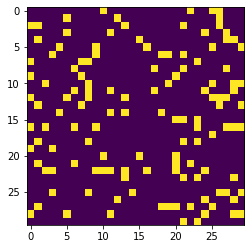

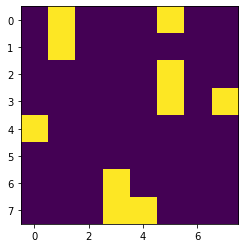

Mean of the hidden space rep: 0.0003939083


In [13]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    #sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    #sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Load the saved model
    sim.load_params("./LIF_ncars")

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0,0].reshape((30, 30)))
    plt.show()

    # display the latent space representation
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_b][0,0].reshape((8, 8)))
    plt.show()

    hidden_rep = output[p_b][0]
    norm = np.linalg.norm(hidden_rep)
    hidden_rep = hidden_rep/norm
    print('Mean of the hidden space rep:', hidden_rep.mean())

In [ ]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    #sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loopq
    #sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Load the saved model
    sim.load_params("./LMU_ncars")

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(np.mean(output[p_c][1],axis=0).reshape((30, 30)))
    plt.show()

    # display the latent space representation
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.figure()
    plt.imshow(np.mean(output[p_b][1],axis=0).reshape((8, 8)))
    plt.show()
    
    plt.figure()
    plt.imshow(np.mean(test_data[1],axis=0).reshape(30,30))

    hidden_rep = output[p_b][0]
    norm = np.linalg.norm(hidden_rep)
    hidden_rep = hidden_rep/norm
    print('Mean of the hidden space rep:', hidden_rep.mean())